# Imports

In [150]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score


import datetime
import holidays


# Set plot style & load data

In [151]:
# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')

# Load processed data
path = '../../data/processed/merged_mbta_weather.csv'
df = pd.read_csv(path)

# Convert service_date to datetime for time-based analysis
df['service_date'] = pd.to_datetime(df['service_date'])

# Feature Engineering

In [152]:
# Feature Engineering

# Weekend Flag
df['day_of_week'] = df['service_date'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Season Flag
def month_to_season(month):
    if month in [12, 1, 2]:
        return 'winter'
    elif month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    else:
        return 'fall'

df['month'] = df['service_date'].dt.month
df['season'] = df['month'].apply(month_to_season)
df = pd.get_dummies(df, columns=['season'], drop_first=True)

# US Holiday-related flags
years = df['service_date'].dt.year.unique().tolist()
us_hols = holidays.US(years=years)
df['is_holiday'] = df['service_date'].apply(lambda d: 1 if d in us_hols else 0)

holiday_dates = sorted(us_hols.keys())

def days_to_next_hol(dt):
    d = dt.date()
    future = [(hol - d).days for hol in holiday_dates if hol >= d]
    return min(future) if future else np.nan

def days_from_prev_hol(dt):
    d = dt.date()
    past = [(d - hol).days for hol in holiday_dates if hol <= d]
    return min(past) if past else np.nan

df['days_to_next_hol']   = df['service_date'].apply(days_to_next_hol)
df['days_from_prev_hol'] = df['service_date'].apply(days_from_prev_hol)

# Compute Week Start (Monday)
df['week_start'] = df['service_date'] - pd.to_timedelta(df['service_date'].dt.weekday, unit='d')

# Lag & Rolling-Window Features
df['lag1']  = df['gated_entries'].shift(1)
df['roll7'] = df['gated_entries'].shift(1).rolling(7).mean()
df = df.dropna()

df['month'] = df['service_date'].dt.month
df['month_norm'] = 2 * np.pi * (df['month'] - 1) / 12
df['month_sin']  = np.sin(df['month_norm'])
df['month_cos']  = np.cos(df['month_norm'])

# COVID-19 related features
df['is_covid_period'] = ((df['service_date'] >= '2020-03-15') & 
                           (df['service_date'] < '2021-03-01')).astype(int)
df['is_recovery_period'] = ((df['service_date'] >= '2021-03-01') & 
                           (df['service_date'] < '2022-01-01')).astype(int)
df['is_post_covid'] = (df['service_date'] >= '2022-01-01').astype(int)
df['covid_weekend'] = df['is_covid_period'] * df['is_weekend']
df['recovery_weekend'] = df['is_recovery_period'] * df['is_weekend']



In [153]:
# Define MBTA line colors and their stations (same as in sortedByLine.ipynb)
line_colors = {
    'Red': ['Alewife', 'Davis', 'Porter', 'Harvard', 'Central', 'Kendall', 'Charles/MGH', 'Park Street', 
            'Downtown Crossing', 'South Station', 'Broadway', 'Andrew', 'JFK/UMass', 'Savin Hill',
            'Fields Corner', 'Shawmut', 'Ashmont', 'North Quincy', 'Wollaston', 'Quincy Center', 
            'Quincy Adams', 'Braintree'],
    'Green': ['Lechmere', 'Science Park', 'North Station', 'Haymarket', 'Government Center', 
              'Park Street', 'Boylston', 'Arlington', 'Copley', 'Hynes', 'Kenmore', 'Prudential',
              'Symphony', 'Northeastern', 'Museum of Fine Arts', 'Longwood Medical Area', 'Brigham Circle',
              'Fenwood Road', 'Mission Park', 'Riverway', 'Back of the Hill', 'Heath Street', 'Cleveland Circle',
              'Beaconsfield', 'Reservoir', 'Chestnut Hill', 'Newton Centre', 'Boston College'],
    'Orange': ['Oak Grove', 'Malden Center', 'Wellington', 'Assembly', 'Sullivan Square', 'Community College',
              'North Station', 'Haymarket', 'State', 'Downtown Crossing', 'Chinatown', 'Tufts Medical Center',
              'Back Bay', 'Massachusetts Avenue', 'Ruggles', 'Roxbury Crossing', 'Jackson Square',
              'Stony Brook', 'Green Street', 'Forest Hills'],
    'Blue': ['Wonderland', 'Revere Beach', 'Beachmont', 'Suffolk Downs', 'Orient Heights', 'Wood Island',
            'Airport', 'Maverick', 'Aquarium', 'State', 'Government Center', 'Bowdoin'],
    'Silver': ['South Station', 'Courthouse', 'World Trade Center']
}

# Add line color based on station names
def assign_line_colors(df, line_colors):
    """Assign MBTA line colors to stations in the dataframe"""
    df['line_color'] = 'Other'  # Default value
    for color, stations in line_colors.items():
        for station in stations:
            mask = df['station_name'].str.contains(station, case=False, na=False)
            df.loc[mask, 'line_color'] = color
    return df

# Looking at Distribution of Gated Entries

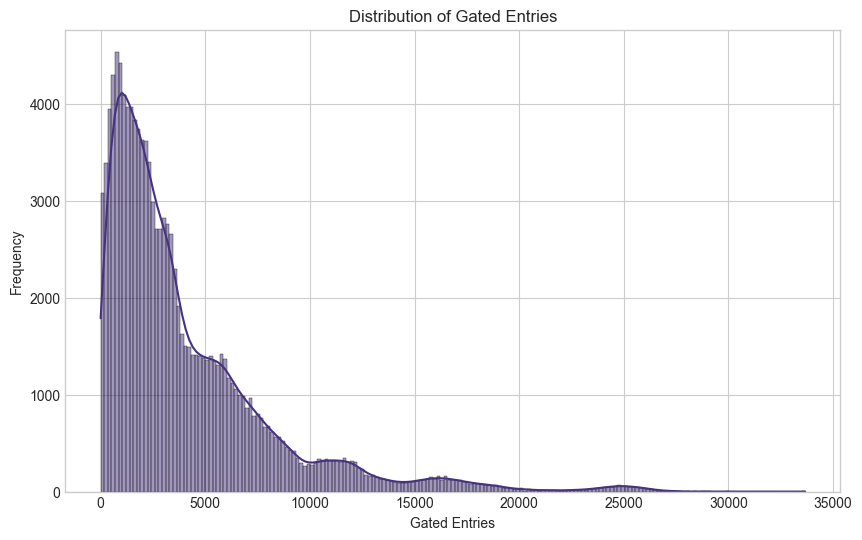

In [154]:
# Assign line colors
df = assign_line_colors(df, line_colors)

# Visualize the distribution of entries
plt.figure(figsize=(10, 6))
sns.histplot(df['gated_entries'], kde=True)
plt.title('Distribution of Gated Entries')
plt.xlabel('Gated Entries')
plt.ylabel('Frequency')
plt.show()

In [155]:
train_mask = df['service_date'] <= '2022-03-01'
test_mask  = df['service_date'] > '2022-03-01'

X_cols = [
    # weather
    'tavg','tmin','tmax','prcp','wspd',
    # calendar
    'is_weekend','is_holiday', 'days_to_next_hol', 'days_from_prev_hol',
    # season one-hots (no season_fall because drop_first=True)
    'season_spring','season_summer','season_winter',
    # lags
    'lag1','roll7',
    # cyclical month
    'month_sin','month_cos',
    # COVID flags
    'is_covid_period','is_recovery_period','is_post_covid', 'covid_weekend', 'recovery_weekend'
]

# Linear Regression Model

No-COVID RMSE: 2467.77,  R²: 0.066
With-COVID RMSE: 2513.11,  R²: 0.031

Top features by coefficient magnitude:
               feature         coef
16     is_covid_period -3455.780830
17  is_recovery_period -2593.507348
5           is_weekend -2290.366095
19       covid_weekend  1936.319102
18       is_post_covid -1924.185369
20    recovery_weekend  1683.740985
6           is_holiday -1362.298251
9        season_spring  -673.567980
10       season_summer  -459.579485
11       season_winter  -365.530135

COVID-flag coefficients:
               feature         coef
16     is_covid_period -3455.780830
17  is_recovery_period -2593.507348
18       is_post_covid -1924.185369


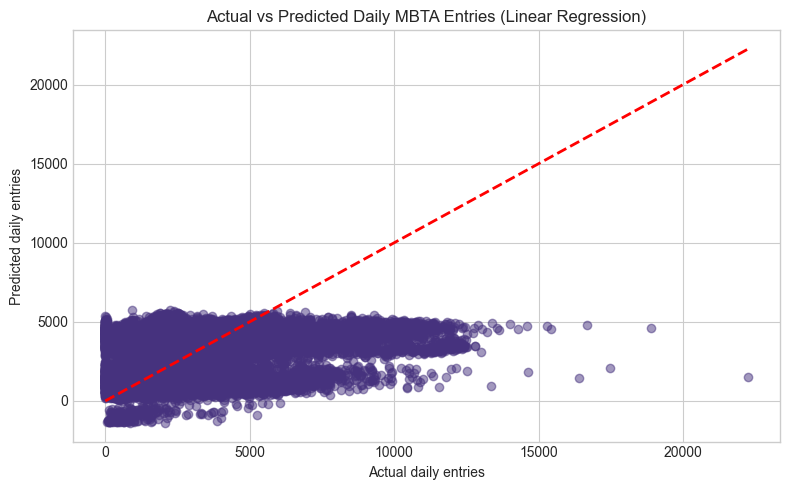

In [156]:
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(df[X_cols])

X_train = df.loc[train_mask, X_cols]
y_train = df.loc[train_mask, 'gated_entries']
X_test  = df.loc[test_mask,  X_cols]
y_test  = df.loc[test_mask,  'gated_entries']

# Fit linear regression
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predict & evaluate
y_pred = lr.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2   = r2_score(y_test, y_pred)

# Without COVID flags
base_feats = [f for f in X_cols if not f.startswith('is_covid')]
lr_base = LinearRegression().fit(X_train[base_feats], y_train)
y_pred_base = lr_base.predict(X_test[base_feats])
rmse_base = np.sqrt(mean_squared_error(y_test, y_pred_base))
r2_base   = r2_score(y_test, y_pred_base)

print(f"No-COVID RMSE: {rmse_base:.2f},  R²: {r2_base:.3f}")
print(f"With-COVID RMSE: {rmse:.2f},  R²: {r2:.3f}")

# Inspect coefficients
coef_df = (
    pd.DataFrame({
        'feature': X_cols,
        'coef':    lr.coef_
    })
    .assign(abs_coef=lambda df: df.coef.abs())
    .sort_values('abs_coef', ascending=False)
    .drop('abs_coef', axis=1)
)
print("\nTop features by coefficient magnitude:")
print(coef_df.head(10))

# Isolate COVID-related rows
covid_coefs = coef_df[
    coef_df['feature'].isin([
        'is_covid_period',
        'is_recovery_period',
        'is_post_covid'
    ])
]
print("\nCOVID-flag coefficients:")
print(covid_coefs)

# Plot actual vs. predicted
plt.figure(figsize=(8,5))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', lw=2)
plt.xlabel('Actual daily entries')
plt.ylabel('Predicted daily entries')
plt.title('Actual vs Predicted Daily MBTA Entries (Linear Regression)')
plt.tight_layout()
plt.show()

# Pipeline Model

Pipeline Test RMSE: 3958.91
Pipeline Test R²  : -1.404

Top 10 polynomial features by |coef|:
roll7^2                 5511.071281
roll7                   4702.948033
lag1 roll7              4297.668239
is_covid_period         2102.340591
is_covid_period^2       2102.340590
is_weekend              1864.820255
is_weekend^2            1864.820234
lag1^2                  1727.966158
is_recovery_period      1592.903098
is_recovery_period^2    1592.903095
dtype: float64


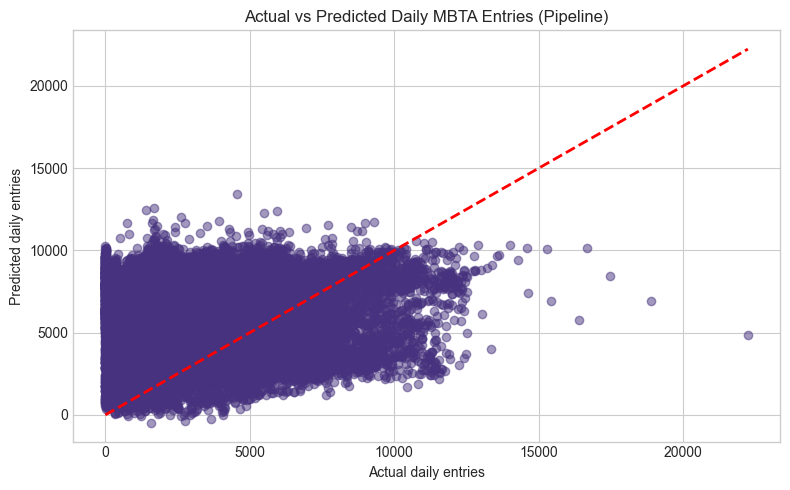

In [157]:
X = df[X_cols]
y = df['gated_entries']

X_train, X_test = X[train_mask], X[~train_mask]
y_train, y_test = y[train_mask], y[~train_mask]

# Build & fit pipeline
tscv = TimeSeriesSplit(n_splits=5)
pipeline = Pipeline([
    ('poly',  PolynomialFeatures(degree=2, include_bias=False)),
    ('scale', StandardScaler()),
    ('ridge', RidgeCV(alphas=[0.1, 1.0, 10.0], cv=tscv))
])
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2   = r2_score(y_test, y_pred)

print(f"Pipeline Test RMSE: {rmse:.2f}")
print(f"Pipeline Test R²  : {r2:.3f}")

# Examine top polynomial terms
coef = pipeline.named_steps['ridge'].coef_
feat_names = pipeline.named_steps['poly'].get_feature_names_out(X_cols)
imp = pd.Series(coef, index=feat_names).abs().nlargest(10)
print("\nTop 10 polynomial features by |coef|:")
print(imp)

# Plot actual vs. predicted
plt.figure(figsize=(8,5))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', lw=2)
plt.xlabel('Actual daily entries')
plt.ylabel('Predicted daily entries')
plt.title('Actual vs Predicted Daily MBTA Entries (Pipeline)')
plt.tight_layout()
plt.show()

# Station-aware Pipeline

In [158]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# One-hot encode station_name
df_enc = pd.get_dummies(df, columns=['station_name'], drop_first=True)
station_dummies = [c for c in df_enc.columns if c.startswith('station_name_')]

# Extend feature list
X_cols_ext = X_cols + station_dummies

# Prepare X/y and split
X = df_enc[X_cols_ext]
y = df_enc['gated_entries']
train_mask = df_enc['service_date'] <= '2022-03-01'

X_train, X_test = X.loc[train_mask], X.loc[~train_mask]
y_train, y_test = y.loc[train_mask], y.loc[~train_mask]

# Build & fit pipeline
tscv = TimeSeriesSplit(n_splits=5)
pipeline = Pipeline([
    ('poly',  PolynomialFeatures(degree=2, include_bias=False)),
    ('scale', StandardScaler()),
    ('ridge', RidgeCV(alphas=[0.1, 1.0, 10.0], cv=tscv))
])
pipeline.fit(X_train, y_train)

# Evaluate
y_pred = pipeline.predict(X_test)
y_pred_clipped = np.clip(y_pred, 0, None)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_clipped))
r2   = r2_score(y_test, y_pred_clipped)

print(f"Station-aware Pipeline RMSE: {rmse:.2f}")
print(f"Station-aware Pipeline R²  : {r2:.3f}")

# Station intercepts
coefs = pipeline.named_steps['ridge'].coef_
feat_names = pipeline.named_steps['poly'].get_feature_names_out(X_cols_ext)
imp = pd.Series(coefs, index=feat_names)
station_effects = imp.filter(like='station_name_').sort_values()
print("\nTop 5 stations above average:")
print(station_effects.tail(5))
print("\nTop 5 stations below average:")
print(station_effects.head(5))

dates = df_enc.loc[~train_mask, 'service_date']

# Plot actual vs. predicted
plt.figure(figsize=(12, 6))
plt.plot(dates, y_test, label='Actual Entries')
plt.plot(dates, y_pred_clipped, label='Predicted Entries', alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Daily Gated Entries')
plt.title('Actual vs Predicted Daily MBTA Entries (Station-aware Pipeline)')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,5))
plt.scatter(y_test, y_pred_clipped, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', lw=2)
plt.xlabel('Actual daily entries')
plt.ylabel('Predicted daily entries')
plt.title('Actual vs Predicted Daily MBTA Entries (Station-aware Pipeline)')
plt.tight_layout()
plt.show()

